In [87]:
#импорт необходимых библеотек 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import ast
import torch
import numpy as np
from tqdm import tqdm
import logging
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, classification_report, accuracy_score, hamming_loss

from torch.nn import BCEWithLogitsLoss

from torch.utils.data import DataLoader


In [92]:
#Загрузим данные и Взглянем на данные

df  = pd.read_csv("разметка комментариев 2.csv")
df.head(10)


,id,rating,comment,Нравится скорость отработки заявок,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Понравилось выполнение заявки,Вопрос решен
0,2945792,5,спасибо,NaN,NaN,NaN,NaN,NaN
1,3234340,5,спасибо!,NaN,NaN,NaN,NaN,NaN
2,3380332,5,Отлично,NaN,NaN,NaN,NaN,NaN
3,3381812,5,Благодарю за оперативное решение проблемы !,NaN,NaN,NaN,NaN,NaN
4,3461991,5,Прекрасный специалист! Побольше таких,NaN,NaN,NaN,NaN,NaN
5,3551430,5,Спасибо,NaN,NaN,NaN,NaN,NaN
6,3572768,1,"пересчет, и скорость \n",NaN,NaN,NaN,NaN,NaN
7,3584536,5,Спасибо за обновление покраски стен,NaN,NaN,NaN,NaN,NaN
8,3596020,5,выполнили быстро,NaN,NaN,NaN,NaN,NaN
9,3617808,5,Спасибо!,NaN,NaN,NaN,NaN,NaN


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2373 entries, 0 to 2372
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    2373 non-null   int64  
 1   rating                                2373 non-null   int64  
 2   comment                               2373 non-null   object 
 3   Нравится скорость отработки заявок    0 non-null      float64
 4   Нравится качество выполнения заявки   0 non-null      float64
 5   Нравится качество работы сотрудников  0 non-null      float64
 6   Понравилось выполнение заявки         0 non-null      float64
 7   Вопрос решен                          0 non-null      float64
dtypes: float64(5), int64(2), object(1)
memory usage: 148.4+ KB


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


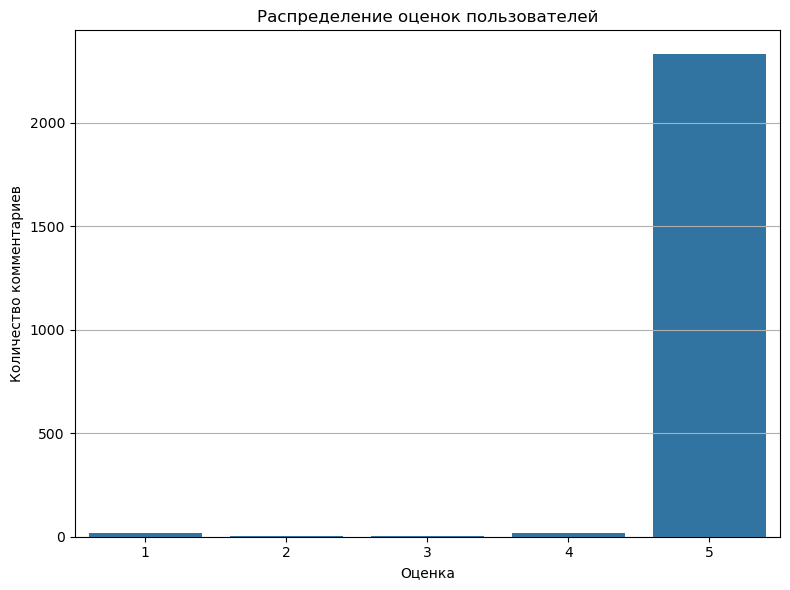

In [94]:
plt.figure(figsize=(8, 6))
sns.countplot(x= "rating",  data = df)

plt.title('Распределение оценок пользователей')
plt.xlabel('Оценка')
plt.ylabel('Количество комментариев')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

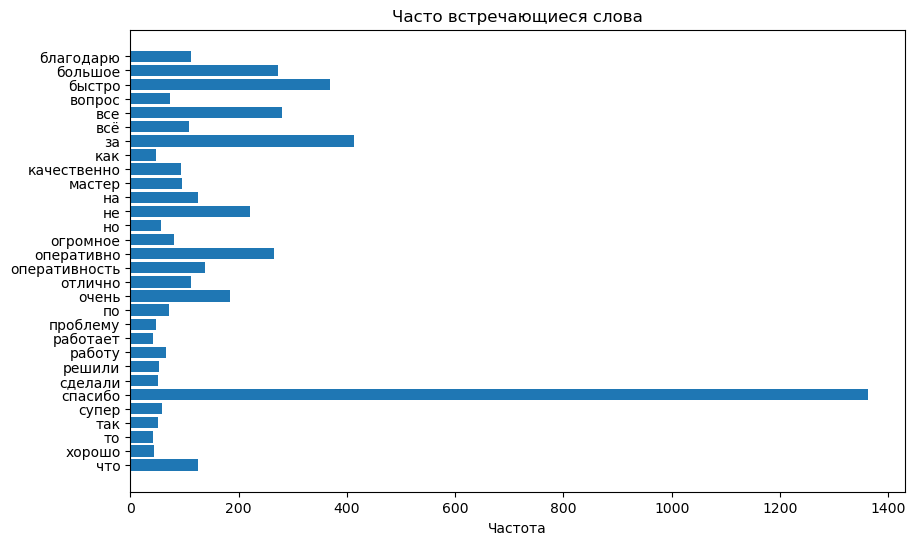

In [95]:
vectorizer = CountVectorizer(max_features=30)
X = vectorizer.fit_transform(df['comment'].astype(str))
word_freq = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()
plt.figure(figsize=(10, 6))
plt.barh(words, word_freq)
plt.title("Часто встречающиеся слова")
plt.xlabel("Частота")
plt.gca().invert_yaxis()
plt.show()

In [96]:
# Данные представляют из себя: 8 колонок, Коментарии о УК Самалёт, Рейтинг, и не размеченные целевые колонки 
# Нравится скорость отработки заявок
# Нравится качество выполнения заявки
# Нравится качество работы сотрудников
# Понравилось выполнение заявки
# Вопрос решен

# В часто встречающехся словах присутвуют стоп-слова такие как "так,на,не,но,все" они не несут никакой смысловой нагрузки , приемущественно слово "Спасибо"

### Данные будем размечать в приложении Labal Studio, этот метод является эфективным на небольшом датасете

In [97]:
### Потратив некоторе время мы обработали данные 

In [3]:
df = pd.read_csv("Размеченные коментарии.csv")
                 

In [99]:
df.head(10)

,annotation_id,annotator,comment,created_at,id,lead_time,rating,sentiment,updated_at,Вопрос решен,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Нравится скорость отработки заявок,Понравилось выполнение заявки
0,7,1,спасибо,2025-05-15T09:25:50.151897Z,2945792,32.642,5,не подходит не к одой теме,2025-05-16T08:36:29.361336Z,NaN,NaN,NaN,NaN,NaN
1,8,1,спасибо!,2025-05-15T09:25:54.082754Z,3234340,2.312,5,не подходит не к одой теме,2025-05-15T09:25:54.082754Z,NaN,NaN,NaN,NaN,NaN
2,3,1,Отлично,2025-05-15T08:21:53.122821Z,3380332,66.186,5,не подходит не к одой теме,2025-05-15T09:26:08.330920Z,NaN,NaN,NaN,NaN,NaN
3,1,1,Благодарю за оперативное решение проблемы !,2025-05-15T07:51:59.448076Z,3381812,94.201,5,"{""choices"":[""Нравится скорость отработки заяво...",2025-05-15T09:26:35.084087Z,NaN,NaN,NaN,NaN,NaN
4,4,1,Прекрасный специалист! Побольше таких,2025-05-15T08:22:05.789675Z,3461991,16.708,5,Нравится качество работы сотрудников,2025-05-15T09:26:47.729758Z,NaN,NaN,NaN,NaN,NaN
5,5,1,Спасибо,2025-05-15T08:22:09.696354Z,3551430,6.849,5,не подходит не к одой теме,2025-05-15T09:26:51.786000Z,NaN,NaN,NaN,NaN,NaN
6,9,1,"пересчет, и скорость \r\n",2025-05-15T09:27:00.707739Z,3572768,7.560,1,не подходит не к одой теме,2025-05-15T09:27:00.707739Z,NaN,NaN,NaN,NaN,NaN
7,10,1,Спасибо за обновление покраски стен,2025-05-15T09:27:23.533477Z,3584536,20.575,5,"{""choices"":[""Нравится качество выполнения заяв...",2025-05-15T09:28:35.083980Z,NaN,NaN,NaN,NaN,NaN
8,11,1,выполнили быстро,2025-05-15T09:27:37.873264Z,3596020,9.323,5,"{""choices"":[""Нравится скорость отработки заяво...",2025-05-15T09:28:26.808341Z,NaN,NaN,NaN,NaN,NaN
9,12,1,Спасибо!,2025-05-15T09:27:42.460809Z,3617808,2.261,5,не подходит не к одой теме,2025-05-15T09:27:42.460809Z,NaN,NaN,NaN,NaN,NaN


In [100]:
# Избавимся от ненужных колонок для более лучшей читаемости  annotation_id,annotator,lead_time,updated_at

In [5]:
df.drop(columns=["annotation_id", "annotator", "lead_time", 'updated_at', "created_at"], inplace=True)

In [102]:
df.head(10)

,comment,id,rating,sentiment,Вопрос решен,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Нравится скорость отработки заявок,Понравилось выполнение заявки
0,спасибо,2945792,5,не подходит не к одой теме,NaN,NaN,NaN,NaN,NaN
1,спасибо!,3234340,5,не подходит не к одой теме,NaN,NaN,NaN,NaN,NaN
2,Отлично,3380332,5,не подходит не к одой теме,NaN,NaN,NaN,NaN,NaN
3,Благодарю за оперативное решение проблемы !,3381812,5,"{""choices"":[""Нравится скорость отработки заяво...",NaN,NaN,NaN,NaN,NaN
4,Прекрасный специалист! Побольше таких,3461991,5,Нравится качество работы сотрудников,NaN,NaN,NaN,NaN,NaN
5,Спасибо,3551430,5,не подходит не к одой теме,NaN,NaN,NaN,NaN,NaN
6,"пересчет, и скорость \r\n",3572768,1,не подходит не к одой теме,NaN,NaN,NaN,NaN,NaN
7,Спасибо за обновление покраски стен,3584536,5,"{""choices"":[""Нравится качество выполнения заяв...",NaN,NaN,NaN,NaN,NaN
8,выполнили быстро,3596020,5,"{""choices"":[""Нравится скорость отработки заяво...",NaN,NaN,NaN,NaN,NaN
9,Спасибо!,3617808,5,не подходит не к одой теме,NaN,NaN,NaN,NaN,NaN


In [103]:
# Удалим дубликаты 

In [7]:
df = df.drop_duplicates()

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2329 entries, 0 to 2367
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   comment                               2329 non-null   object 
 1   id                                    2329 non-null   int64  
 2   rating                                2329 non-null   int64  
 3   sentiment                             2329 non-null   object 
 4   Вопрос решен                          0 non-null      float64
 5   Нравится качество выполнения заявки   0 non-null      float64
 6   Нравится качество работы сотрудников  0 non-null      float64
 7   Нравится скорость отработки заявок    0 non-null      float64
 8   Понравилось выполнение заявки         0 non-null      float64
dtypes: float64(5), int64(2), object(2)
memory usage: 182.0+ KB


In [9]:

target_labels = {
    'Нравится скорость отработки заявок',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Понравилось выполнение заявки',
    'Вопрос решен'
}

# Функция разметки целевых колонок
def parse_targets(sentiment):
    labels = {label: 0 for label in target_labels}
    if isinstance(sentiment, str):
        try:
            data = ast.literal_eval(sentiment)
            if isinstance(data, dict) and "choices" in data:
                for label in data["choices"]:
                    if label in labels:
                        labels[label] = 1
        except:
            if sentiment.strip() in labels:
                labels[sentiment.strip()] = 1
    return pd.Series(labels)

# Применяем к DataFrame
target_columns = df['sentiment'].apply(parse_targets)
df[target_columns.columns] = target_columns



In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2329 entries, 0 to 2367
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   comment                               2329 non-null   object
 1   id                                    2329 non-null   int64 
 2   rating                                2329 non-null   int64 
 3   sentiment                             2329 non-null   object
 4   Вопрос решен                          2329 non-null   int64 
 5   Нравится качество выполнения заявки   2329 non-null   int64 
 6   Нравится качество работы сотрудников  2329 non-null   int64 
 7   Нравится скорость отработки заявок    2329 non-null   int64 
 8   Понравилось выполнение заявки         2329 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 182.0+ KB


In [108]:
df.head(10)

,comment,id,rating,sentiment,Вопрос решен,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Нравится скорость отработки заявок,Понравилось выполнение заявки
0,спасибо,2945792,5,не подходит не к одой теме,0,0,0,0,0
1,спасибо!,3234340,5,не подходит не к одой теме,0,0,0,0,0
2,Отлично,3380332,5,не подходит не к одой теме,0,0,0,0,0
3,Благодарю за оперативное решение проблемы !,3381812,5,"{""choices"":[""Нравится скорость отработки заяво...",0,0,0,1,1
4,Прекрасный специалист! Побольше таких,3461991,5,Нравится качество работы сотрудников,0,0,1,0,0
5,Спасибо,3551430,5,не подходит не к одой теме,0,0,0,0,0
6,"пересчет, и скорость \r\n",3572768,1,не подходит не к одой теме,0,0,0,0,0
7,Спасибо за обновление покраски стен,3584536,5,"{""choices"":[""Нравится качество выполнения заяв...",1,1,0,0,1
8,выполнили быстро,3596020,5,"{""choices"":[""Нравится скорость отработки заяво...",1,0,0,1,0
9,Спасибо!,3617808,5,не подходит не к одой теме,0,0,0,0,0


In [11]:
df = df[df['sentiment'] != 'не подходит не к одой теме']


In [110]:
df.info(10)

<class 'pandas.core.frame.DataFrame'>
Index: 1239 entries, 3 to 2367
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   comment                               1239 non-null   object
 1   id                                    1239 non-null   int64 
 2   rating                                1239 non-null   int64 
 3   sentiment                             1239 non-null   object
 4   Вопрос решен                          1239 non-null   int64 
 5   Нравится качество выполнения заявки   1239 non-null   int64 
 6   Нравится качество работы сотрудников  1239 non-null   int64 
 7   Нравится скорость отработки заявок    1239 non-null   int64 
 8   Понравилось выполнение заявки         1239 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 96.8+ KB


In [111]:
# Обработаем оставшийся текст кометнарий уберём стоп-слова, знаки припенания, цифры и пустый строк если таки происутсвуют

In [13]:
stopwords_ru = set([
    'а', 'без', 'был', 'была', 'были', 'быть', 'в', 'во', 'всё', 'все', 'да', 'для', 'до',
    'его', 'ее', 'если', 'есть', 'же', 'за', 'и', 'из', 'или', 'их', 'к', 'как', 'ко', 'когда',
    'который', 'ли', 'либо', 'мне', 'может', 'мы', 'на', 'надо', 'наш', 'не', 'него', 'нее',
    'нет', 'ни', 'но', 'ну', 'о', 'об', 'однако', 'он', 'она', 'они', 'оно', 'от', 'очень',
    'по', 'под', 'при', 'с', 'со', 'так', 'также', 'там', 'те', 'тем', 'то', 'того', 'тоже',
    'той', 'только', 'том', 'ты', 'у', 'уже', 'хотя', 'чего', 'чей', 'чем', 'что', 'чтобы',
    'чье', 'эта', 'эти', 'это', 'я'
])


df['comment'] = df['comment'].apply(
    lambda text: ' '.join([
        word for word in str(text).lower().split()
        if word not in stopwords_ru and word.isalpha() and len(word) >= 3
    ])
)

In [113]:
df.head(15)

,comment,id,rating,sentiment,Вопрос решен,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Нравится скорость отработки заявок,Понравилось выполнение заявки
3,благодарю оперативное решение проблемы,3381812,5,"{""choices"":[""Нравится скорость отработки заяво...",0,0,0,1,1
4,прекрасный побольше таких,3461991,5,Нравится качество работы сотрудников,0,0,1,0,0
7,спасибо обновление покраски стен,3584536,5,"{""choices"":[""Нравится качество выполнения заяв...",1,1,0,0,1
8,выполнили быстро,3596020,5,"{""choices"":[""Нравится скорость отработки заяво...",1,0,0,1,0
10,спасибо управляющей компании прислали грамотно...,3627490,5,Нравится качество работы сотрудников,0,0,1,0,0
13,решили мой,3695420,5,"{""choices"":[""Понравилось выполнение заявки"",""В...",1,0,0,0,1
14,радует работа,3716702,5,"{""choices"":[""Нравится скорость отработки заяво...",1,1,1,1,1
15,исправили,3726842,5,Вопрос решен,1,0,0,0,0
16,спасибо оперативную работу,3745025,5,Нравится скорость отработки заявок,0,0,0,1,0
17,выполнили отлично обработка заявки слишком дор...,3749719,5,"{""choices"":[""Нравится качество выполнения заяв...",1,1,0,0,0


In [114]:
# Логироварине

In [15]:
logging.basicConfig(level=logging.INFO)

In [17]:
labels = [
    'Нравится скорость отработки заявок',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Понравилось выполнение заявки',
    'Вопрос решен'
]
df['R1'] = (df[labels].sum(axis=1) > 0).astype(int)

In [19]:
# Стратифицированное разделение
stratify_col = df[labels].sum(axis=1)


In [21]:
# Модель Токенизация 
MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


In [23]:
class CommentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        # Токенизируем все комментарии заранее
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=128)
        self.labels = labels  # Набор меток на каждую строку (5 значений на комментарий)

    def __getitem__(self, idx):
        # Возвращаем словарь: токенизированный текст + метки
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)  # Для multi-label нужна float
        return item

    def __len__(self):
        return len(self.labels)  



In [25]:
# Кросс-валидация StratifiedKFold 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_scores = []


In [27]:
# Списки для оценок и сохранение лучшей модели 

In [29]:
roc_scores = []
f1_macro_scores = []
best_model = None
best_score = -1
best_fold = -1

In [31]:
for fold, (train_idx, test_idx) in enumerate(skf.split(df, stratify_col)):
    logging.info(f"Fold {fold + 1}")

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    train_dataset = CommentDataset(train_df['comment'], train_df[labels].values)
    test_dataset = CommentDataset(test_df['comment'], test_df[labels].values)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(labels),
        problem_type="multi_label_classification"
    )

    def compute_metrics(eval_pred):
        logits, labels_true = eval_pred
        probs = torch.sigmoid(torch.tensor(logits)).numpy()
        preds = (probs > 0.5).astype(int)
        return {
            "roc_auc": roc_auc_score(labels_true, probs, average="macro"),
            "f1_macro": f1_score(labels_true, preds, average="macro")
        }

    # Упрощённые аргументы обучения для старых версий transformers
    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold + 1}",
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        logging_dir=f"./logs_fold_{fold + 1}",
        logging_steps=10
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()

    preds = trainer.predict(test_dataset)
    logits = preds.predictions
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    y_true = test_df[labels].values
    y_pred = (probs > 0.5).astype(int)

    roc = roc_auc_score(y_true, probs, average="macro")
    f1_macro = f1_score(y_true, y_pred, average="macro")

    roc_scores.append(roc)
    f1_macro_scores.append(f1_macro)

    if f1_macro > best_score:
        best_score = f1_macro
        best_model = model
        best_fold = fold + 1

    logging.info(f"Fold {fold + 1} ROC-AUC: {roc:.4f}, F1-macro: {f1_macro:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=labels, digits=3))

C:\Users\Aadmin\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
INFO:root:Fold 1
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.633100
20,0.530300
30,0.508400
40,0.434300
50,0.448500
60,0.461800
70,0.417100
80,0.414500
90,0.413800
100,0.437800


INFO:root:Fold 1 ROC-AUC: 0.8252, F1-macro: 0.5435
C:\Users\Aadmin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
INFO:root:Fold 2



Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок      0.830     0.830     0.830       147
 Нравится качество выполнения заявки      0.706     0.300     0.421        40
Нравится качество работы сотрудников      0.766     0.537     0.632        67
       Понравилось выполнение заявки      0.500     0.095     0.160        21
                        Вопрос решен      0.675     0.675     0.675        80

                           micro avg      0.766     0.637     0.695       355
                           macro avg      0.695     0.487     0.544       355
                        weighted avg      0.749     0.637     0.672       355
                         samples avg      0.765     0.686     0.702       355



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.596200
20,0.548700
30,0.484900
40,0.516200
50,0.514700
60,0.453800
70,0.456300
80,0.455800
90,0.397200
100,0.393900


INFO:root:Fold 2 ROC-AUC: 0.8305, F1-macro: 0.5964
C:\Users\Aadmin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
INFO:root:Fold 3



Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок      0.844     0.890     0.866       164
 Нравится качество выполнения заявки      0.476     0.263     0.339        38
Нравится качество работы сотрудников      0.902     0.649     0.755        57
       Понравилось выполнение заявки      0.556     0.227     0.323        22
                        Вопрос решен      0.708     0.689     0.699        74

                           micro avg      0.788     0.701     0.742       355
                           macro avg      0.697     0.544     0.596       355
                        weighted avg      0.768     0.701     0.723       355
                         samples avg      0.820     0.773     0.773       355



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.633800
20,0.553800
30,0.549700
40,0.499800
50,0.509300
60,0.466200
70,0.480900
80,0.542100
90,0.444600
100,0.476900


INFO:root:Fold 3 ROC-AUC: 0.7987, F1-macro: 0.5161
INFO:root:Fold 4



Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок      0.824     0.813     0.819       150
 Нравится качество выполнения заявки      0.579     0.379     0.458        29
Нравится качество работы сотрудников      0.778     0.681     0.726        72
       Понравилось выполнение заявки      0.000     0.000     0.000        25
                        Вопрос решен      0.651     0.519     0.577        79

                           micro avg      0.759     0.628     0.687       355
                           macro avg      0.566     0.478     0.516       355
                        weighted avg      0.698     0.628     0.659       355
                         samples avg      0.781     0.691     0.709       355



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.582500
20,0.489600
30,0.520300
40,0.499000
50,0.538300
60,0.413400
70,0.416600
80,0.470100
90,0.474700
100,0.457100


INFO:root:Fold 4 ROC-AUC: 0.8070, F1-macro: 0.5820
C:\Users\Aadmin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
INFO:root:Fold 5



Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок      0.836     0.867     0.851       165
 Нравится качество выполнения заявки      0.810     0.395     0.531        43
Нравится качество работы сотрудников      0.759     0.707     0.732        58
       Понравилось выполнение заявки      0.667     0.087     0.154        23
                        Вопрос решен      0.652     0.632     0.642        68

                           micro avg      0.781     0.689     0.732       357
                           macro avg      0.745     0.538     0.582       357
                        weighted avg      0.774     0.689     0.709       357
                         samples avg      0.796     0.753     0.748       357



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.612800
20,0.521600
30,0.497400
40,0.480300
50,0.454500
60,0.475800
70,0.475600
80,0.446800
90,0.516700
100,0.447400


INFO:root:Fold 5 ROC-AUC: 0.8079, F1-macro: 0.5366



Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок      0.854     0.893     0.873       150
 Нравится качество выполнения заявки      0.733     0.324     0.449        34
Нравится качество работы сотрудников      0.837     0.707     0.766        58
       Понравилось выполнение заявки      0.000     0.000     0.000        23
                        Вопрос решен      0.710     0.512     0.595        86

                           micro avg      0.807     0.655     0.723       351
                           macro avg      0.627     0.487     0.537       351
                        weighted avg      0.748     0.655     0.689       351
                         samples avg      0.809     0.705     0.732       351



C:\Users\Aadmin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [124]:
logging.info(f"Средний ROC-AUC по 5 фолдам: {np.mean(roc_scores):.4f}")
logging.info(f"Средний F1-macro по 5 фолдам: {np.mean(f1_macro_scores):.4f}")
logging.info(f"Лучшая модель с фолда {best_fold} (F1-macro: {best_score:.4f})")


INFO:root:Средний ROC-AUC по 5 фолдам: 0.7966
INFO:root:Средний F1-macro по 5 фолдам: 0.5173
INFO:root:Лучшая модель с фолда 2 (F1-macro: 0.5962)


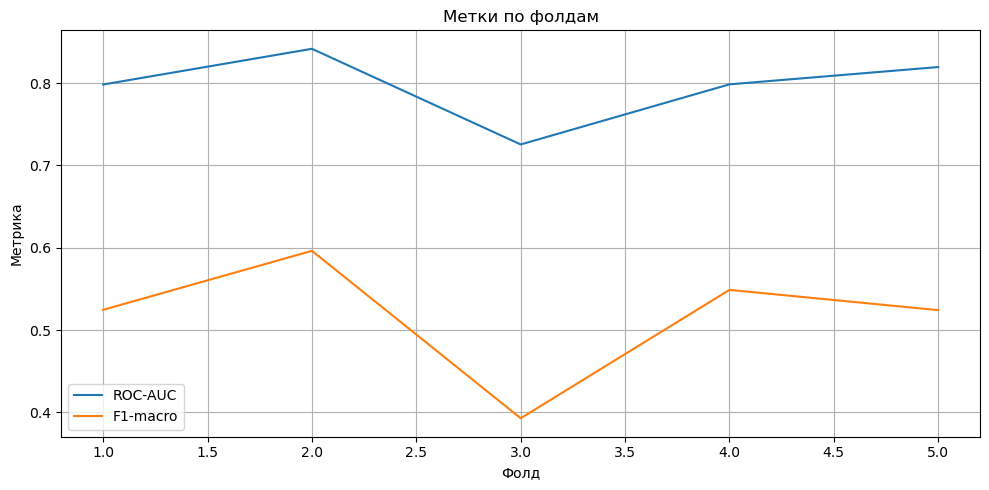

In [125]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=list(range(1, 6)), y=roc_scores, label='ROC-AUC')
sns.lineplot(x=list(range(1, 6)), y=f1_macro_scores, label='F1-macro')
plt.title("Метки по фолдам")
plt.xlabel("Фолд")
plt.ylabel("Метрика")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("metrics_by_fold.png")
plt.show()



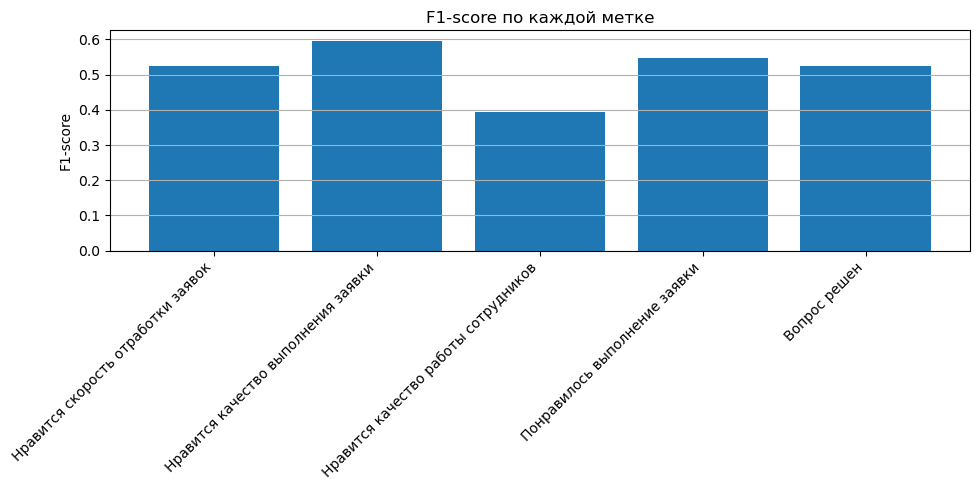

In [126]:
plt.figure(figsize=(10, 5))
plt.bar(labels, f1_macro_scores)
plt.ylabel("F1-score")
plt.title("F1-score по каждой метке")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [127]:
# поиск оптимального порога бинаризации вероятностей

In [131]:
best_thresh = 0.5
best_f1 = 0
for t in np.arange(0.3, 0.7, 0.05):
    temp_pred = (probs > t).astype(int)
    score = f1_score(y_true, temp_pred, average="macro")
    if score > best_f1:
        best_f1 = score
        best_thresh = t

logging.info(f"Оптимальный порог: {best_thresh:.2f}, F1-macro: {best_f1:.4f}")

INFO:root:Оптимальный порог: 0.30, F1-macro: 0.5977


In [133]:
print("GPU активен:", torch.cuda.is_available())
print("Устройство:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

GPU активен: True
Устройство: NVIDIA GeForce RTX 2060 SUPER


In [135]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()


In [139]:
for fold, (train_idx, test_idx) in enumerate(skf.split(df, stratify_col)):
    logging.info(f"Fold {fold + 1}")

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    train_dataset = CommentDataset(train_df['comment'], train_df[labels].values)
    test_dataset = CommentDataset(test_df['comment'], test_df[labels].values)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(labels),
        problem_type="multi_label_classification"
    )

    def compute_metrics(eval_pred):
        logits, labels_true = eval_pred
        probs = torch.sigmoid(torch.tensor(logits)).numpy()
        preds = (probs > 0.30).astype(int)
        return {
            "roc_auc": roc_auc_score(labels_true, probs, average="macro"),
            "f1_macro": f1_score(labels_true, preds, average="macro")
        }

    # Упрощённые аргументы обучения для старых версий transformers
    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold + 1}",
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        logging_dir=f"./logs_fold_{fold + 1}",
        logging_steps=10
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()

    preds = trainer.predict(test_dataset)
    logits = preds.predictions
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    y_true = test_df[labels].values
    y_pred = (probs > 0.3).astype(int)

    roc = roc_auc_score(y_true, probs, average="macro")
    f1_macro = f1_score(y_true, y_pred, average="macro")

    roc_scores.append(roc)
    f1_macro_scores.append(f1_macro)

    if f1_macro > best_score:
        best_score = f1_macro
        best_model = model
        best_fold = fold + 1

    logging.info(f"Fold {fold + 1} ROC-AUC: {roc:.4f}, F1-macro: {f1_macro:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=labels, digits=3))




C:\Users\Aadmin\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
INFO:root:Fold 1
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.606300
20,0.522900
30,0.519500
40,0.421700
50,0.458800
60,0.480300
70,0.432200
80,0.437100
90,0.439800
100,0.468400


INFO:root:Fold 1 ROC-AUC: 0.8203, F1-macro: 0.6251
C:\Users\Aadmin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
INFO:root:Fold 2



Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок      0.796     0.905     0.847       147
 Нравится качество выполнения заявки      0.586     0.425     0.493        40
Нравится качество работы сотрудников      0.701     0.701     0.701        67
       Понравилось выполнение заявки      0.444     0.381     0.410        21
                        Вопрос решен      0.604     0.762     0.674        80

                           micro avg      0.696     0.749     0.722       355
                           macro avg      0.627     0.635     0.625       355
                        weighted avg      0.691     0.749     0.715       355
                         samples avg      0.742     0.780     0.734       355



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.641200
20,0.556300
30,0.490400
40,0.510000
50,0.513200
60,0.444100
70,0.443400
80,0.438100
90,0.394600
100,0.398000


INFO:root:Fold 2 ROC-AUC: 0.8416, F1-macro: 0.6243
INFO:root:Fold 3



Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок      0.816     0.945     0.876       164
 Нравится качество выполнения заявки      0.484     0.395     0.435        38
Нравится качество работы сотрудников      0.808     0.737     0.771        57
       Понравилось выполнение заявки      0.353     0.273     0.308        22
                        Вопрос решен      0.678     0.797     0.733        74

                           micro avg      0.735     0.780     0.757       355
                           macro avg      0.628     0.629     0.624       355
                        weighted avg      0.722     0.780     0.747       355
                         samples avg      0.807     0.837     0.792       355



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.623200
20,0.554100
30,0.546600
40,0.484400
50,0.493200
60,0.452500
70,0.463200
80,0.569100
90,0.485100
100,0.504100


INFO:root:Fold 3 ROC-AUC: 0.7254, F1-macro: 0.4133
C:\Users\Aadmin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
INFO:root:Fold 4



Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок      0.724     0.873     0.792       150
 Нравится качество выполнения заявки      0.000     0.000     0.000        29
Нравится качество работы сотрудников      0.699     0.708     0.703        72
       Понравилось выполнение заявки      0.000     0.000     0.000        25
                        Вопрос решен      0.561     0.582     0.571        79

                           micro avg      0.679     0.642     0.660       355
                           macro avg      0.397     0.433     0.413       355
                        weighted avg      0.572     0.642     0.604       355
                         samples avg      0.735     0.705     0.687       355



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.569100
20,0.485100
30,0.520300
40,0.504800
50,0.552700
60,0.447800
70,0.438700
80,0.468400
90,0.483700
100,0.436900


INFO:root:Fold 4 ROC-AUC: 0.7985, F1-macro: 0.5861
INFO:root:Fold 5



Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок      0.809     0.897     0.851       165
 Нравится качество выполнения заявки      0.654     0.395     0.493        43
Нравится качество работы сотрудников      0.683     0.741     0.711        58
       Понравилось выполнение заявки      0.294     0.217     0.250        23
                        Вопрос решен      0.573     0.691     0.627        68

                           micro avg      0.701     0.728     0.714       357
                           macro avg      0.602     0.588     0.586       357
                        weighted avg      0.692     0.728     0.703       357
                         samples avg      0.756     0.778     0.738       357



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.641900
20,0.525400
30,0.493500
40,0.488500
50,0.469100
60,0.464100
70,0.498600
80,0.451300
90,0.538800
100,0.458100


INFO:root:Fold 5 ROC-AUC: 0.8195, F1-macro: 0.5977



Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок      0.783     0.913     0.843       150
 Нравится качество выполнения заявки      0.538     0.412     0.467        34
Нравится качество работы сотрудников      0.763     0.776     0.769        58
       Понравилось выполнение заявки      0.364     0.174     0.235        23
                        Вопрос решен      0.663     0.686     0.674        86

                           micro avg      0.719     0.738     0.729       351
                           macro avg      0.622     0.592     0.598       351
                        weighted avg      0.699     0.738     0.713       351
                         samples avg      0.758     0.771     0.736       351



C:\Users\Aadmin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [132]:
logging.info(f"Средний ROC-AUC по 5 фолдам: {np.mean(roc_scores):.4f}")
logging.info(f"Средний F1-macro по 5 фолдам: {np.mean(f1_macro_scores):.4f}")
logging.info(f"Лучшая модель с фолда {best_fold} (F1-macro: {best_score:.4f})")


INFO:root:Средний ROC-AUC по 5 фолдам: 0.7965
INFO:root:Средний F1-macro по 5 фолдам: 0.5391
INFO:root:Лучшая модель с фолда 2 (F1-macro: 0.6243)


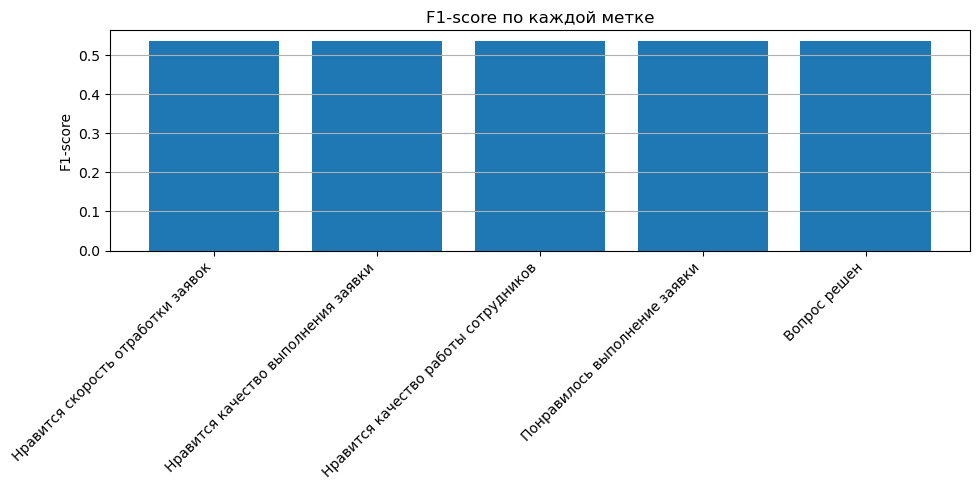

In [32]:
plt.figure(figsize=(10, 5))
plt.bar(labels, f1_macro)
plt.ylabel("F1-score")
plt.title("F1-score по каждой метке")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [37]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()


In [134]:
# метрика F1-macro = 0.5977 и ROC-AUC = 0.8195 на 5-м фолде метрика F1 указывает на большой дисбаланс класса
# Попробуем sberbank-ai но для привёдём баланс классов редким меткам  "Понравилось выполнение заявки" будет присвоен высокий вес,

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [136]:
print("GPU активен:", torch.cuda.is_available())
print("Устройство:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

GPU активен: True
Устройство: NVIDIA GeForce RTX 2060 SUPER


In [29]:
df['R1'] = (df[labels].sum(axis=1) > 0).astype(int)
stratify_col = df[labels].sum(axis=1)

In [31]:
MODEL_NAME = "sberbank-ai/ruBert-large"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [32]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_scores = []
f1_macro_scores = []
best_score = 0
best_fold = None
best_model = None


C:\Users\Aadmin\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
INFO:root:Fold 1
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.584300
20,0.536300
30,0.519800
40,0.451700
50,0.472800
60,0.490700
70,0.446900
80,0.444600
90,0.480100
100,0.508600


INFO:root:Fold 1 ROC-AUC: 0.8166, F1-macro: 0.5729


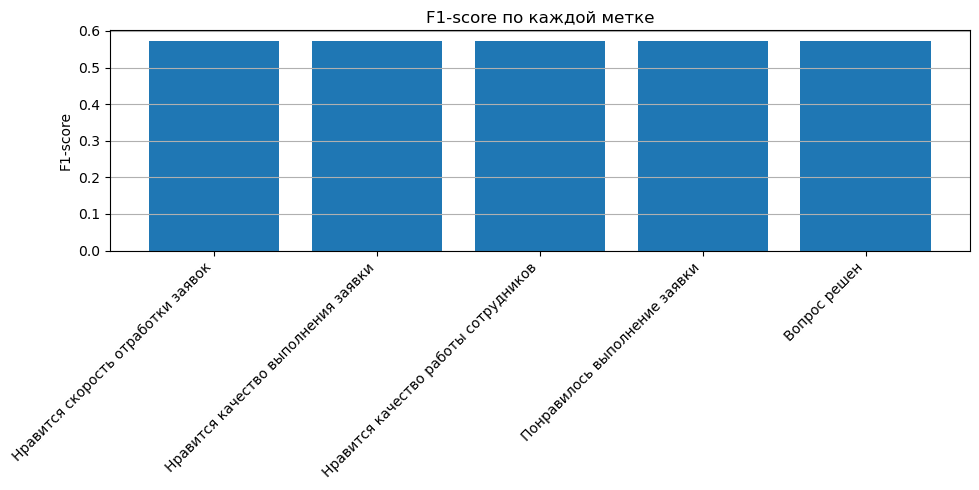

INFO:root:Fold 2
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.565500
20,0.546200
30,0.489500
40,0.503000
50,0.484600
60,0.411200
70,0.437800
80,0.431800
90,0.393700
100,0.405900


INFO:root:Fold 2 ROC-AUC: 0.8410, F1-macro: 0.6017


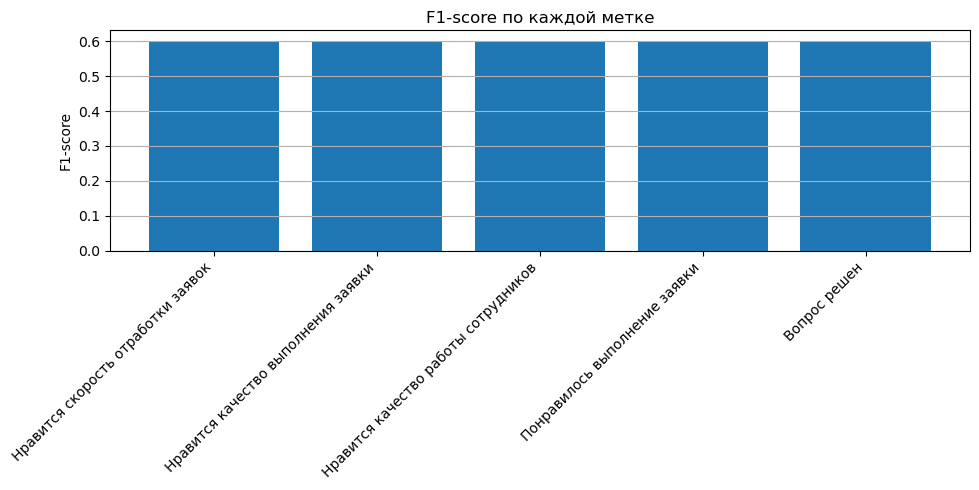

INFO:root:Fold 3
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.585800
20,0.552800
30,0.553600
40,0.483100
50,0.448600
60,0.414800
70,0.498300
80,0.575200
90,0.487100
100,0.523200


INFO:root:Fold 3 ROC-AUC: 0.8024, F1-macro: 0.6012


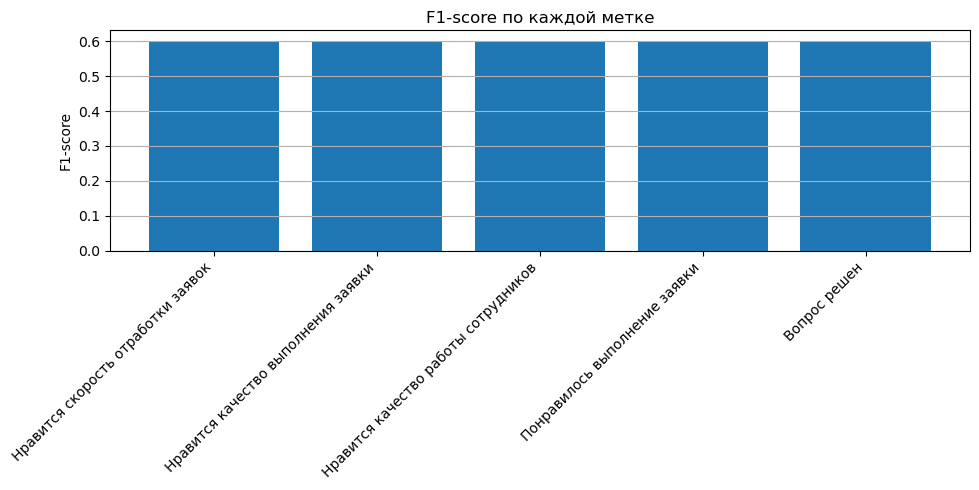

INFO:root:Fold 4
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.534100
20,0.479700
30,0.507200
40,0.476700
50,0.544800
60,0.420600
70,0.433100
80,0.455400
90,0.473900
100,0.401600


INFO:root:Fold 4 ROC-AUC: 0.8153, F1-macro: 0.5838


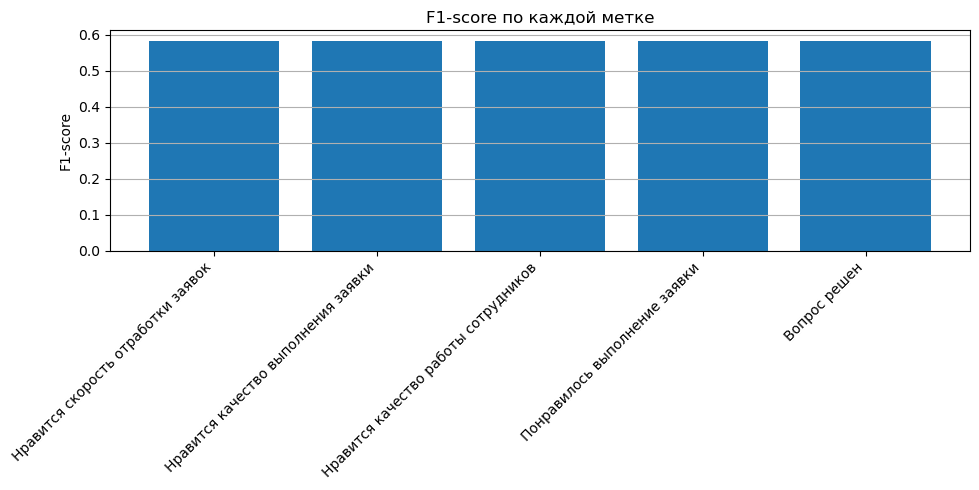

INFO:root:Fold 5
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.579300
20,0.522900
30,0.507200
40,0.491100
50,0.469400
60,0.461900
70,0.490200
80,0.433700
90,0.516000
100,0.434100


INFO:root:Fold 5 ROC-AUC: 0.8223, F1-macro: 0.5781


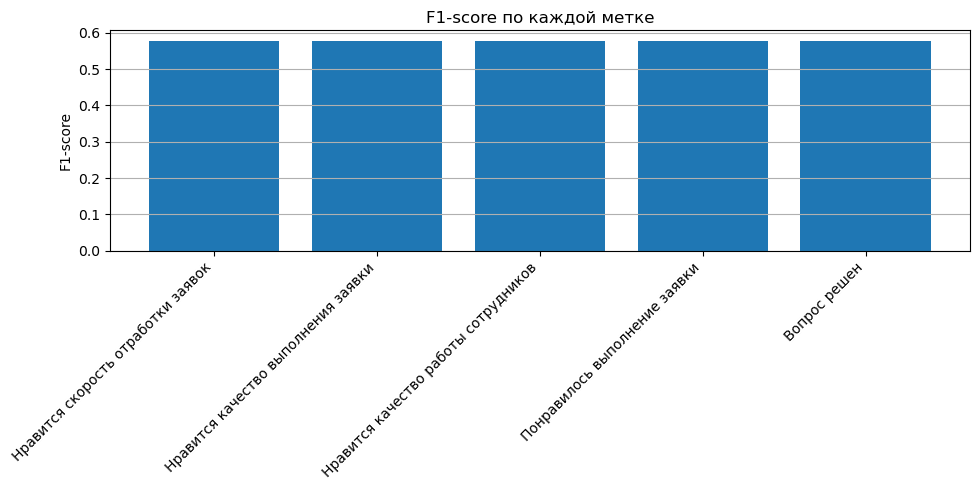

In [39]:
for fold, (train_idx, test_idx) in enumerate(skf.split(df, stratify_col)):
    logging.info(f"Fold {fold + 1}")

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    train_dataset = CommentDataset(train_df['comment'], train_df[labels].values)
    test_dataset = CommentDataset(test_df['comment'], test_df[labels].values)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(labels),
        problem_type="multi_label_classification"
    ).to(device)

    def compute_metrics(eval_pred):
        logits, labels_true = eval_pred
        probs = torch.sigmoid(torch.tensor(logits)).numpy()
        preds = (probs > 0.3).astype(int)
        return {
            "roc_auc": roc_auc_score(labels_true, probs, average="macro"),
            "f1_macro": f1_score(labels_true, preds, average="macro")
        }

    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold + 1}",
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        logging_dir=f"./logs_fold_{fold + 1}",
        logging_steps=10,
        fp16=torch.cuda.is_available(),
        no_cuda=not torch.cuda.is_available()
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()

    preds = trainer.predict(test_dataset)
    logits = preds.predictions
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    y_true = test_df[labels].values
    y_pred = (probs > 0.5).astype(int)

    roc = roc_auc_score(y_true, probs, average="macro")
    f1_macro = f1_score(y_true, y_pred, average="macro")

    roc_scores.append(roc)
    f1_macro_scores.append(f1_macro)

    if f1_macro > best_score:
        best_score = f1_macro
        best_model = model
        best_fold = fold + 1

    logging.info(f"Fold {fold + 1} ROC-AUC: {roc:.4f}, F1-macro: {f1_macro:.4f}")
    
    del trainer, model
    gc.collect()
    torch.cuda.empty_cache()
    
    plt.figure(figsize=(10, 5))
    plt.bar(labels, f1_macro)
    plt.ylabel("F1-score")
    plt.title("F1-score по каждой метке")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

In [41]:
logging.info(f"Средний ROC-AUC по 5 фолдам: {np.mean(roc_scores):.4f}")
logging.info(f"Средний F1-macro по 5 фолдам: {np.mean(f1_macro_scores):.4f}")
logging.info(f"Лучшая модель с фолда {best_fold} (F1-macro: {best_score:.4f})")


INFO:root:Средний ROC-AUC по 5 фолдам: 0.8217
INFO:root:Средний F1-macro по 5 фолдам: 0.5841
INFO:root:Лучшая модель с фолда 2 (F1-macro: 0.6017)


In [35]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()


In [37]:
# Попробуем cointegrated

In [39]:
MODEL_NAME = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [41]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_scores = []
f1_macro_scores = []
best_model = None
best_score = -1
best_fold = -1


In [45]:
for fold, (train_idx, test_idx) in enumerate(skf.split(df, stratify_col)):
    logging.info(f"Fold {fold + 1}")

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    train_dataset = CommentDataset(train_df['comment'], train_df[labels].values)
    test_dataset = CommentDataset(test_df['comment'], test_df[labels].values)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(labels),
        problem_type="multi_label_classification"
    )

    def compute_metrics(eval_pred):
        logits, labels_true = eval_pred
        probs = torch.sigmoid(torch.tensor(logits)).numpy()
        preds = (probs > 0.30).astype(int)
        return {
            "roc_auc": roc_auc_score(labels_true, probs, average="macro"),
            "f1_macro": f1_score(labels_true, preds, average="macro")
        }

    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold + 1}",
        num_train_epochs=4,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        logging_dir=f"./logs_fold_{fold + 1}",
        logging_steps=10,
        fp16=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()

    preds = trainer.predict(test_dataset)
    logits = preds.predictions
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    y_true = test_df[labels].values
    y_pred = (probs > 0.30).astype(int)

    roc = roc_auc_score(y_true, probs, average="macro")
    f1_macro = f1_score(y_true, y_pred, average="macro")

    roc_scores.append(roc)
    f1_macro_scores.append(f1_macro)

    if f1_macro > best_score:
        best_score = f1_macro
        best_model = model
        best_fold = fold + 1
        model.save_pretrained(f"./best_model_fold_{best_fold}")
        tokenizer.save_pretrained(f"./best_model_fold_{best_fold}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=labels, digits=3))



C:\Users\Aadmin\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
INFO:root:Fold 1
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.670400
20,0.599100
30,0.542800
40,0.525800
50,0.551500
60,0.480100
70,0.482100
80,0.475000
90,0.473100
100,0.449600


C:\Users\Aadmin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
INFO:root:Fold 2



Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок      0.649     0.993     0.785       147
 Нравится качество выполнения заявки      0.000     0.000     0.000        40
Нравится качество работы сотрудников      0.595     0.701     0.644        67
       Понравилось выполнение заявки      0.000     0.000     0.000        21
                        Вопрос решен      0.550     0.825     0.660        80

                           micro avg      0.609     0.730     0.664       355
                           macro avg      0.359     0.504     0.418       355
                        weighted avg      0.505     0.730     0.595       355
                         samples avg      0.683     0.786     0.692       355



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.659500
20,0.597400
30,0.557000
40,0.533200
50,0.489600
60,0.506200
70,0.509600
80,0.484700
90,0.484300
100,0.485100


INFO:root:Fold 3
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок      0.716     0.982     0.828       164
 Нравится качество выполнения заявки      1.000     0.158     0.273        38
Нравится качество работы сотрудников      0.630     0.807     0.708        57
       Понравилось выполнение заявки      0.500     0.045     0.083        22
                        Вопрос решен      0.547     0.784     0.644        74

                           micro avg      0.660     0.766     0.709       355
                           macro avg      0.679     0.555     0.507       355
                        weighted avg      0.684     0.766     0.665       355
                         samples avg      0.730     0.820     0.739       355



Step,Training Loss
10,0.661000
20,0.595300
30,0.536400
40,0.527800
50,0.498600
60,0.506600
70,0.492000
80,0.466900
90,0.501700
100,0.459700


INFO:root:Fold 4



Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок      0.656     0.980     0.786       150
 Нравится качество выполнения заявки      0.538     0.241     0.333        29
Нравится качество работы сотрудников      0.608     0.819     0.698        72
       Понравилось выполнение заявки      0.400     0.080     0.133        25
                        Вопрос решен      0.565     0.823     0.670        79

                           micro avg      0.617     0.789     0.692       355
                           macro avg      0.554     0.589     0.524       355
                        weighted avg      0.599     0.789     0.660       355
                         samples avg      0.683     0.821     0.711       355



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.650200
20,0.590900
30,0.551500
40,0.543800
50,0.522300
60,0.504600
70,0.473200
80,0.482900
90,0.473100
100,0.501100


INFO:root:Fold 5
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок      0.700     0.945     0.804       165
 Нравится качество выполнения заявки      0.667     0.047     0.087        43
Нравится качество работы сотрудников      0.568     0.793     0.662        58
       Понравилось выполнение заявки      0.000     0.000     0.000        23
                        Вопрос решен      0.491     0.794     0.607        68

                           micro avg      0.616     0.723     0.665       357
                           macro avg      0.485     0.516     0.432       357
                        weighted avg      0.589     0.723     0.605       357
                         samples avg      0.684     0.777     0.690       357



Step,Training Loss
10,0.656500
20,0.585500
30,0.539900
40,0.532100
50,0.540200
60,0.499800
70,0.477200
80,0.495700
90,0.485800
100,0.480200



Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок      0.646     0.987     0.781       150
 Нравится качество выполнения заявки      0.400     0.059     0.103        34
Нравится качество работы сотрудников      0.595     0.810     0.686        58
       Понравилось выполнение заявки      0.000     0.000     0.000        23
                        Вопрос решен      0.640     0.744     0.688        86

                           micro avg      0.624     0.744     0.679       351
                           macro avg      0.456     0.520     0.452       351
                        weighted avg      0.570     0.744     0.626       351
                         samples avg      0.695     0.790     0.701       351



In [53]:

logging.info(f"Средний ROC-AUC: {np.mean(roc_scores):.4f}")
logging.info(f"Средний F1-macro: {np.mean(f1_macro_scores):.4f}")

INFO:root:Средний ROC-AUC: 0.7756
INFO:root:Средний F1-macro: 0.4665


INFO:root:Лучшая модель: фолд 3 (F1-macro: 0.5242)


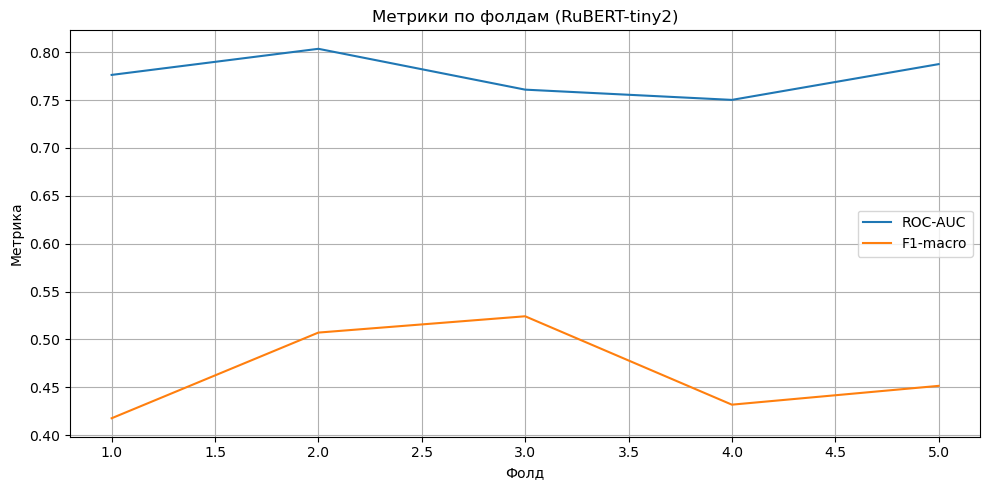

In [55]:
logging.info(f"Лучшая модель: фолд {best_fold} (F1-macro: {best_score:.4f})")

plt.figure(figsize=(10, 5))
sns.lineplot(x=list(range(1, 6)), y=roc_scores, label='ROC-AUC')
sns.lineplot(x=list(range(1, 6)), y=f1_macro_scores, label='F1-macro')
plt.title("Метрики по фолдам (RuBERT-tiny2)")
plt.xlabel("Фолд")
plt.ylabel("Метрика")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("metrics_rubert_tiny2.png")
plt.show()


In [57]:
logging.info(f"Средний ROC-AUC: {np.mean(roc_scores):.4f}")
logging.info(f"Средний F1-macro: {np.mean(f1_macro_scores):.4f}")
logging.info(f"Лучшая модель: фолд {best_fold} (F1-macro: {best_score:.4f})")


INFO:root:Средний ROC-AUC: 0.7756
INFO:root:Средний F1-macro: 0.4665
INFO:root:Лучшая модель: фолд 3 (F1-macro: 0.5242)


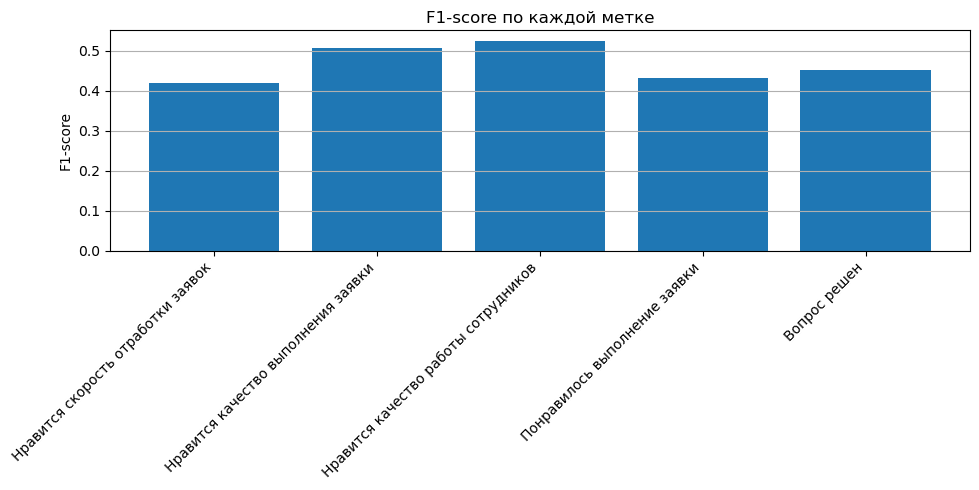

In [59]:
plt.figure(figsize=(10, 5))
plt.bar(labels, f1_macro_scores)
plt.ylabel("F1-score")
plt.title("F1-score по каждой метке")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [61]:
gc.collect()
torch.cuda.empty_cache()


In [57]:
from torch.nn import BCEWithLogitsLoss 

In [41]:
MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


In [43]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_scores = []
f1_macro_scores = []
best_model = None
best_score = -1
best_fold = -1


In [45]:
for fold, (train_idx, test_idx) in enumerate(skf.split(df, stratify_col)):
    # Расчёт весов классов по train_df
    class_counts = df.iloc[train_idx][labels].sum()
    class_weights = 1 / np.log(class_counts + 1)
    class_weights /= class_weights.max()
    class_weights = torch.tensor(class_weights.values, dtype=torch.float).to(device)
    logging.info(f"Fold {fold + 1}")

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    train_dataset = CommentDataset(train_df['comment'], train_df[labels].values)
    test_dataset = CommentDataset(test_df['comment'], test_df[labels].values)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(labels),
        problem_type="multi_label_classification"
    ).to(device)

    def compute_metrics(eval_pred):
        logits, labels_true = eval_pred
        probs = torch.sigmoid(torch.tensor(logits)).numpy()
        preds = (probs > 0.3).astype(int)
        return {
            "roc_auc": roc_auc_score(labels_true, probs, average="macro"),
            "f1_macro": f1_score(labels_true, preds, average="macro")
        }

    class WeightedTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, **kwargs):

            labels = inputs.pop("labels")
            outputs = model(**inputs)
            logits = outputs.logits
            loss_fct = BCEWithLogitsLoss(pos_weight=class_weights)
            loss = loss_fct(logits, labels)
            return (loss, outputs) if return_outputs else loss

    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold + 1}",
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        logging_dir=f"./logs_fold_{fold + 1}",
        logging_steps=10,
        fp16=torch.cuda.is_available(),
        no_cuda=not torch.cuda.is_available()
    )

    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()

    preds = trainer.predict(test_dataset)
    logits = preds.predictions
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    y_true = test_df[labels].values
    y_pred = (probs > 0.3).astype(int)

    roc = roc_auc_score(y_true, probs, average="macro")
    f1_macro = f1_score(y_true, y_pred, average="macro")

    roc_scores.append(roc)
    f1_macro_scores.append(f1_macro)

    if f1_macro > best_score:
        best_score = f1_macro
        best_model = model
        best_fold = fold + 1
        # Сохраняем модель и токенизатор лучшего фолда
        model.save_pretrained(f"./best_model_fold_{best_fold}")
        tokenizer.save_pretrained(f"./best_model_fold_{best_fold}")

    logging.info(f"Fold {fold + 1} ROC-AUC: {roc:.4f}, F1-macro: {f1_macro:.4f}")

    del trainer, model
    gc.collect()
    torch.cuda.empty_cache()

C:\Users\Aadmin\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
INFO:root:Fold 1
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.543900
20,0.459600
30,0.465500
40,0.386700
50,0.401300
60,0.416500
70,0.385600
80,0.383000
90,0.388900
100,0.427500


INFO:root:Fold 1 ROC-AUC: 0.7982, F1-macro: 0.5676
INFO:root:Fold 2
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.590900
20,0.497000
30,0.433000
40,0.459100
50,0.470300
60,0.396900
70,0.415900
80,0.395000
90,0.359800
100,0.354700


INFO:root:Fold 2 ROC-AUC: 0.8324, F1-macro: 0.6426
INFO:root:Fold 3
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.549500
20,0.484200
30,0.492800
40,0.428300
50,0.426300
60,0.399500
70,0.391000
80,0.490900
90,0.383800
100,0.402800


INFO:root:Fold 3 ROC-AUC: 0.7953, F1-macro: 0.5901
INFO:root:Fold 4
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.519000
20,0.436100
30,0.461600
40,0.447900
50,0.487000
60,0.368400
70,0.390700
80,0.416600
90,0.441000
100,0.413000


INFO:root:Fold 4 ROC-AUC: 0.8018, F1-macro: 0.5763
INFO:root:Fold 5
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.557100
20,0.463000
30,0.436300
40,0.424300
50,0.398600
60,0.409000
70,0.438400
80,0.387700
90,0.441600
100,0.400700


INFO:root:Fold 5 ROC-AUC: 0.8138, F1-macro: 0.6053


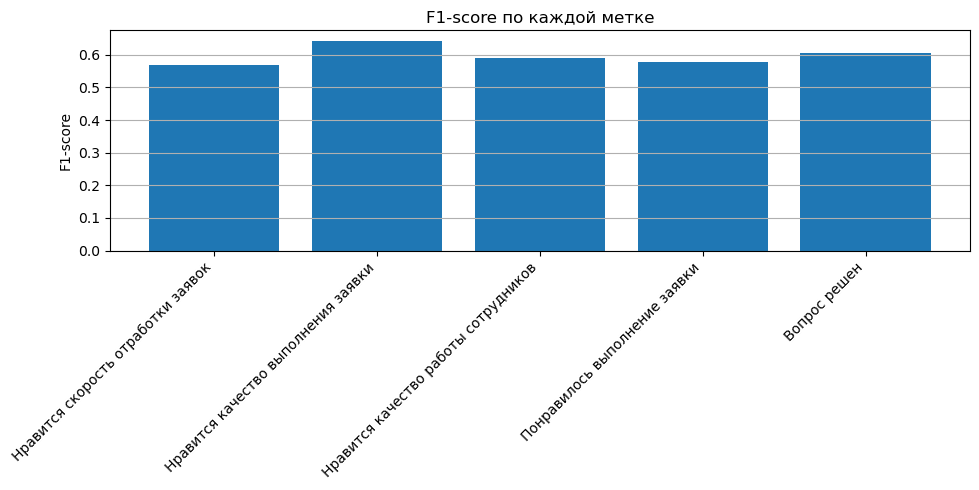

In [47]:
plt.figure(figsize=(10, 5))
plt.bar(labels, f1_macro_scores)
plt.ylabel("F1-score")
plt.title("F1-score по каждой метке")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [49]:
best_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [69]:
print(f"Лучший ROC-AUC : {roc_scores[1]} f1_marco : {f1_macro_scores[1]}")

Лучший ROC-AUC : 0.8324422265008403 f1_marco : 0.642559134566869


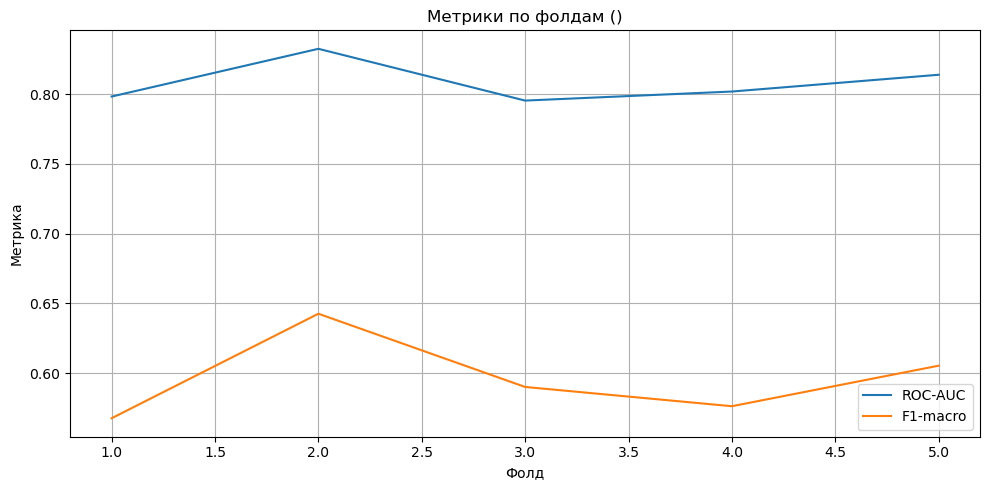

In [63]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=list(range(1, 6)), y=roc_scores, label='ROC-AUC')
sns.lineplot(x=list(range(1, 6)), y=f1_macro_scores, label='F1-macro')
plt.title("Метрики по фолдам ()")
plt.xlabel("Фолд")
plt.ylabel("Метрика")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("metrics_rubert_tiny2.png")
plt.show()

In [97]:
MODEL_PATH = "./best_model_fold_2"  # путь к лучшей модели
MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

In [99]:
from transformers import BertForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
model = BertForSequenceClassification.from_pretrained(MODEL_PATH)
model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

In [101]:


test_dataset = CommentDataset(test_df['comment'], test_df[labels].values)
loader = DataLoader(test_dataset, batch_size=8)

all_logits = []
with torch.no_grad():
    for batch in loader:
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        all_logits.append(outputs.logits.cpu())


In [91]:

logits = torch.cat(all_logits, dim=0).numpy()
probs = torch.sigmoid(torch.tensor(logits)).numpy()
y_true = test_df[labels].values

threshold = 0.3 
y_pred = (probs > threshold).astype(int)

roc = roc_auc_score(y_true, probs, average="macro")
f1_macro = f1_score(y_true, y_pred, average="macro")
print(f"ROC-AUC: {roc:.4f}, F1-macro: {f1_macro:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels, digits=3))

# === Очистка ===
del model, logits, probs, y_pred
gc.collect()
torch.cuda.empty_cache()


ROC-AUC: 0.9667, F1-macro: 0.8631

Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок      0.961     0.980     0.970       150
 Нравится качество выполнения заявки      0.893     0.735     0.806        34
Нравится качество работы сотрудников      0.950     0.983     0.966        58
       Понравилось выполнение заявки      0.750     0.652     0.698        23
                        Вопрос решен      0.856     0.895     0.875        86

                           micro avg      0.915     0.915     0.915       351
                           macro avg      0.882     0.849     0.863       351
                        weighted avg      0.913     0.915     0.913       351
                         samples avg      0.943     0.938     0.928       351



In [49]:
df = pd.read_csv("Размеченные коментарии.csv")
       

In [51]:

df.drop(columns=["annotation_id", "annotator", "lead_time", 'updated_at', "created_at"], inplace=True)    
df = df.drop_duplicates()


In [53]:


target_labels = {
    'Нравится скорость отработки заявок',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Понравилось выполнение заявки',
    'Вопрос решен'
}

# Функция разметки целевых колонок
def parse_targets(sentiment):
    labels = {label: 0 for label in target_labels}
    if isinstance(sentiment, str):
        try:
            data = ast.literal_eval(sentiment)
            if isinstance(data, dict) and "choices" in data:
                for label in data["choices"]:
                    if label in labels:
                        labels[label] = 1
        except:
            if sentiment.strip() in labels:
                labels[sentiment.strip()] = 1
    return pd.Series(labels)

target_columns = df['sentiment'].apply(parse_targets)
df[target_columns.columns] = target_columns



In [55]:
df = df[df['sentiment'] != 'не подходит не к одой теме']      

In [59]:
MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_scores = []
f1_macro_scores = []
best_model = None
best_score = -1
best_fold = -1



In [67]:
for fold, (train_idx, test_idx) in enumerate(skf.split(df, stratify_col)):
    # Расчёт весов классов по train_df
    class_counts = df.iloc[train_idx][labels].sum()
    class_weights = 1 / np.log(class_counts + 1)
    class_weights /= class_weights.max()
    class_weights = torch.tensor(class_weights.values, dtype=torch.float).to(device)
    logging.info(f"Fold {fold + 1}")

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    train_dataset = CommentDataset(train_df['comment'], train_df[labels].values)
    test_dataset = CommentDataset(test_df['comment'], test_df[labels].values)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(labels),
        problem_type="multi_label_classification"
    ).to(device)

    def compute_metrics(eval_pred):
        logits, labels_true = eval_pred
        probs = torch.sigmoid(torch.tensor(logits)).numpy()
        preds = (probs > 0.3).astype(int)
        return {
            "roc_auc": roc_auc_score(labels_true, probs, average="macro"),
            "f1_macro": f1_score(labels_true, preds, average="macro")
        }

    class WeightedTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, **kwargs):

            labels = inputs.pop("labels")
            outputs = model(**inputs)
            logits = outputs.logits
            loss_fct = BCEWithLogitsLoss(pos_weight=class_weights)
            loss = loss_fct(logits, labels)
            return (loss, outputs) if return_outputs else loss

    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold + 1}",
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        logging_dir=f"./logs_fold_{fold + 1}",
        logging_steps=10,
        fp16=torch.cuda.is_available(),
        no_cuda=not torch.cuda.is_available()
    )

    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()

    preds = trainer.predict(test_dataset)
    logits = preds.predictions
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    y_true = test_df[labels].values
    y_pred = (probs > 0.3).astype(int)

    roc = roc_auc_score(y_true, probs, average="macro")
    f1_macro = f1_score(y_true, y_pred, average="macro")

    roc_scores.append(roc)
    f1_macro_scores.append(f1_macro)

    if f1_macro > best_score:
        best_score = f1_macro
        best_model = model
        best_fold = fold + 1
        # Сохраняем модель и токенизатор лучшего фолда
        model.save_pretrained(f"./best_model_fold_new{best_fold}")
        tokenizer.save_pretrained(f"./best_model_fold_new{best_fold}")

    logging.info(f"Fold {fold + 1} ROC-AUC: {roc:.4f}, F1-macro: {f1_macro:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=labels, digits=3))

    del trainer, model
    gc.collect()
    torch.cuda.empty_cache()


C:\Users\Aadmin\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
INFO:root:Fold 1
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.564000
20,0.465200
30,0.443000
40,0.368600
50,0.357300
60,0.350000
70,0.320200
80,0.336600
90,0.279600
100,0.345300


INFO:root:Fold 1 ROC-AUC: 0.9300, F1-macro: 0.7485
C:\Users\Aadmin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок      0.916     0.959     0.937       147
 Нравится качество выполнения заявки      0.725     0.725     0.725        40
Нравится качество работы сотрудников      0.786     0.821     0.803        67
       Понравилось выполнение заявки      0.500     0.571     0.533        21
                        Вопрос решен      0.670     0.838     0.744        80

                           micro avg      0.784     0.856     0.818       355
                           macro avg      0.719     0.783     0.749       355
                        weighted avg      0.790     0.856     0.820       355
                         samples avg      0.843     0.896     0.846       355



INFO:root:Fold 2
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.566700
20,0.495400
30,0.425200
40,0.452300
50,0.428200
60,0.350700
70,0.353600
80,0.325800
90,0.291300
100,0.263900


INFO:root:Fold 2 ROC-AUC: 0.9218, F1-macro: 0.7589



Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок      0.924     0.957     0.940       164
 Нравится качество выполнения заявки      0.649     0.632     0.640        38
Нравится качество работы сотрудников      0.833     0.877     0.855        57
       Понравилось выполнение заявки      0.565     0.591     0.578        22
                        Вопрос решен      0.744     0.824     0.782        74

                           micro avg      0.820     0.859     0.839       355
                           macro avg      0.743     0.776     0.759       355
                        weighted avg      0.820     0.859     0.839       355
                         samples avg      0.877     0.897     0.869       355



INFO:root:Fold 3
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.555600
20,0.486000
30,0.471300
40,0.407600
50,0.377800
60,0.355000
70,0.338000
80,0.374100
90,0.306900
100,0.276900


INFO:root:Fold 3 ROC-AUC: 0.8989, F1-macro: 0.7166



Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок      0.902     0.920     0.911       150
 Нравится качество выполнения заявки      0.553     0.724     0.627        29
Нравится качество работы сотрудников      0.861     0.861     0.861        72
       Понравилось выполнение заявки      0.500     0.480     0.490        25
                        Вопрос решен      0.648     0.747     0.694        79

                           micro avg      0.772     0.823     0.797       355
                           macro avg      0.693     0.746     0.717       355
                        weighted avg      0.780     0.823     0.800       355
                         samples avg      0.837     0.869     0.825       355



INFO:root:Fold 4
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.503700
20,0.423100
30,0.449700
40,0.434000
50,0.470200
60,0.340700
70,0.352600
80,0.339900
90,0.323700
100,0.338300


INFO:root:Fold 4 ROC-AUC: 0.8851, F1-macro: 0.6876
C:\Users\Aadmin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок      0.917     0.933     0.925       165
 Нравится качество выполнения заявки      0.738     0.721     0.729        43
Нравится качество работы сотрудников      0.797     0.879     0.836        58
       Понравилось выполнение заявки      0.353     0.261     0.300        23
                        Вопрос решен      0.634     0.662     0.647        68

                           micro avg      0.793     0.804     0.798       357
                           macro avg      0.688     0.691     0.688       357
                        weighted avg      0.785     0.804     0.794       357
                         samples avg      0.840     0.855     0.822       357



INFO:root:Fold 5
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.592800
20,0.474800
30,0.440500
40,0.409300
50,0.360000
60,0.356200
70,0.331200
80,0.290600
90,0.333200
100,0.301700


INFO:root:Fold 5 ROC-AUC: 0.9084, F1-macro: 0.7212



Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок      0.918     0.967     0.942       150
 Нравится качество выполнения заявки      0.647     0.647     0.647        34
Нравится качество работы сотрудников      0.845     0.845     0.845        58
       Понравилось выполнение заявки      0.500     0.391     0.439        23
                        Вопрос решен      0.702     0.767     0.733        86

                           micro avg      0.804     0.829     0.816       351
                           macro avg      0.722     0.723     0.721       351
                        weighted avg      0.799     0.829     0.813       351
                         samples avg      0.851     0.867     0.838       351



In [69]:
best_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [73]:

f1_macro_scores 

[0.7256625967521074,
 0.748514912443787,
 0.7589299350017912,
 0.7165562874575967,
 0.6875768555579577,
 0.7211605149743971]

In [75]:
roc_scores 

[0.9288421493430956,
 0.9300436312477964,
 0.9218103305070826,
 0.8988844208686446,
 0.8851495111358736,
 0.9083509765561274]

In [77]:
MODEL_PATH = "./best_model_fold_new2"  # путь к лучшей модели
MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

In [93]:
model = BertForSequenceClassification.from_pretrained(MODEL_PATH)
model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [95]:
logits = torch.cat(all_logits, dim=0).numpy()
probs = torch.sigmoid(torch.tensor(logits)).numpy()
y_true = test_df[labels].values

threshold = 0.3 
y_pred = (probs > threshold).astype(int)

roc = roc_auc_score(y_true, probs, average="macro")
f1_macro = f1_score(y_true, y_pred, average="macro")
print(f"ROC-AUC: {roc:.4f}, F1-macro: {f1_macro:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels, digits=3))

# === Очистка ===
del model, logits, probs, y_pred
gc.collect()
torch.cuda.empty_cache()


ROC-AUC: 0.9667, F1-macro: 0.8631

Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок      0.961     0.980     0.970       150
 Нравится качество выполнения заявки      0.893     0.735     0.806        34
Нравится качество работы сотрудников      0.950     0.983     0.966        58
       Понравилось выполнение заявки      0.750     0.652     0.698        23
                        Вопрос решен      0.856     0.895     0.875        86

                           micro avg      0.915     0.915     0.915       351
                           macro avg      0.882     0.849     0.863       351
                        weighted avg      0.913     0.915     0.913       351
                         samples avg      0.943     0.938     0.928       351

